A model based off T5 that receives the entire paragraph including the sentence to be corrected. The target sentence is surrounded with custom tokens so the model knows which sentence to correct the grammar of and output.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%capture
!pip install torch torchvision
!pip install accelerate
!pip install transformers
!pip install transformers[torch]
!pip install datasets
!pip install errant

In [ ]:
from collections import namedtuple

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
)
from tokenizers import AddedToken
from datasets import load_dataset
import spacy
import errant

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/CS4248/datasets/train.json'
VAL_PATH = '/content/drive/MyDrive/CS4248/datasets/val.json'
TEST_PATH = '/content/drive/MyDrive/CS4248/datasets/test.json'

OUT_DIR = '/content/drive/MyDrive/CS4248/results_para_t5_small'
SAVE_DIR = '/content/drive/MyDrive/CS4248/para_t5_model'

TEST_M2_PATH = '/content/drive/MyDrive/CS4248/datasets/test.m2'
OUT_M2_PATH = '/content/drive/MyDrive/CS4248/out.m2'

MODEL = 't5-small'
TARGET_SENTENCE_START_TOKEN = '<SS>'
TARGET_SENTENCE_END_TOKEN = '<ES>'
TASK_PREFIX = 'rectify'
TOKENIZER_PADDING = 'max_length'
MAX_LENGTH = 512
BATCH_SIZE = 8
LEARNING_RATE = 3e-4
EPOCHS = 5
NUM_WORKERS = 2

GEN_MAX_LENGTH = 512
GEN_NUM_BEAMS = 5

In [ ]:
dataset_train = load_dataset(
    'json',
    data_files=TRAIN_PATH,
    split='train'
)
dataset_val = load_dataset(
    'json',
    data_files=VAL_PATH,
    split='train'
)
dataset_test = load_dataset(
    'json',
    data_files=TEST_PATH,
    split='train'
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL)
tokenizer.add_special_tokens({
    "additional_special_tokens": [AddedToken(TARGET_SENTENCE_START_TOKEN), AddedToken(TARGET_SENTENCE_END_TOKEN)]
})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2

In [ ]:
tokenizer('<SS> Hi <ES>')

{'input_ids': [32100, 2018, 32101, 1], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
def preprocess_function(dataset):
    inputs = []
    for para, pos in zip(dataset['paragraph'], dataset['pos']):
        joined_para = ' '.join(
            f'{TARGET_SENTENCE_START_TOKEN} {sent} {TARGET_SENTENCE_END_TOKEN}' if i == pos else sent
            for i, sent in enumerate(para)
        )
        inputs.append(f'{TASK_PREFIX}: {joined_para}')
    model_inputs = tokenizer(
        inputs,
        text_target=dataset['corrected'],
        max_length=MAX_LENGTH,
        padding=TOKENIZER_PADDING,
        truncation=True,
        return_tensors='pt',
    )
    return model_inputs

tokenized_train = dataset_train.map(
    preprocess_function,
    batched=True,
    num_proc=8
)
tokenized_val = dataset_val.map(
    preprocess_function,
    batched=True,
    num_proc=8
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/28066 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/6996 [00:00<?, ? examples/s]

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(MODEL)
model.resize_token_embeddings(len(tokenizer))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32102, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32102, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=EPOCHS,
    logging_dir=OUT_DIR,
    evaluation_strategy='steps',
    save_steps=1000,
    eval_steps=1000,
    learning_rate=LEARNING_RATE,
    load_best_model_at_end=True,
    save_total_limit=2,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

# history = trainer.train()
history = trainer.train(resume_from_checkpoint=True)
model.save_pretrained(SAVE_DIR)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Step,Training Loss,Validation Loss
12000,0.009800,0.013538
13000,0.009800,0.013586
14000,0.009300,0.013277
15000,0.008500,0.013570


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

# history = trainer.train()
history = trainer.train(resume_from_checkpoint=True)
model.save_pretrained(SAVE_DIR)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Step,Training Loss,Validation Loss
16000,0.008500,0.013543
17000,0.008800,0.013501


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL)
tokenizer.add_special_tokens({
    "additional_special_tokens": [AddedToken(TARGET_SENTENCE_START_TOKEN), AddedToken(TARGET_SENTENCE_END_TOKEN)]
})
model = T5ForConditionalGeneration.from_pretrained(SAVE_DIR)
model.resize_token_embeddings(len(tokenizer))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32102, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32102, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
spacy_tokenizer = nlp.tokenizer
annotator = errant.load('en')

In [ ]:
def generate_correction(model, tokenizer, sample):
    joined_para = ' '.join(
        f'{TARGET_SENTENCE_START_TOKEN} {sent} {TARGET_SENTENCE_END_TOKEN}' if i == sample['pos'] else sent
        for i, sent in enumerate(sample['paragraph'])
    )
    input_text = f'{TASK_PREFIX}: {joined_para}'
    inputs = tokenizer.encode(
        input_text,
        max_length=MAX_LENGTH,
        padding=TOKENIZER_PADDING,
        truncation=True,
        return_tensors='pt',
    ).to(device)
    corrected_ids = model.generate(
        inputs,
        max_length=GEN_MAX_LENGTH,
        num_beams=GEN_NUM_BEAMS,
        early_stopping=True
    )
    corrected_sentence = tokenizer.decode(
        corrected_ids[0],
        skip_special_tokens=True
    )
    # Retokenize sentence using spacy to restore correct spacing between tokens
    # for accurate f0.5 score calculation
    corrected_sentence = ' '.join(tok.text for tok in nlp.tokenizer(corrected_sentence))
    return corrected_sentence

In [ ]:
NOOP_EDIT = 'A -1 -1|||noop|||-NONE-|||REQUIRED|||-NONE-|||0'

with open(OUT_M2_PATH, 'w', encoding='utf-8') as f:
    for sample in dataset_test:
        orig = sample['original']
        corrected = generate_correction(model, tokenizer, sample)
        edits = annotator.annotate(annotator.parse(orig), annotator.parse(corrected))
        print('S', orig, file=f)
        if not edits:
            print(NOOP_EDIT, file=f)
        for edit in edits:
            print(edit.to_m2(), file=f)
        print(file=f)  # Blank divider line

In [ ]:
# Compare output edits with gold-standard edits and computes statistics
!errant_compare -hyp {OUT_M2_PATH} -ref {TEST_M2_PATH}


=========== Span-Based Correction ============
TP	FP	FN	Prec	Rec	F0.5
2275	2065	5179	0.5242	0.3052	0.4584



In [ ]:
!errant_compare -hyp {OUT_M2_PATH} -ref {TEST_M2_PATH} -ds


============ Span-Based Detection ============
TP	FP	FN	Prec	Rec	F0.5
2783	1571	4842	0.6392	0.365	0.5557



In [ ]:
!errant_compare -hyp {OUT_M2_PATH} -ref {TEST_M2_PATH} -ds -cat 1


====================== Span-Based Detection ======================
Category       TP       FP       FN       P        R        F0.5
M              886      526      1123     0.6275   0.441    0.5786
R              1621     774      3045     0.6768   0.3474   0.5689
U              264      271      515      0.4935   0.3389   0.4522
UNK            12       0        159      1.0      0.0702   0.274

============ Span-Based Detection ============
TP	FP	FN	Prec	Rec	F0.5
2783	1571	4842	0.6392	0.365	0.5557



In [ ]:
!errant_compare -hyp {OUT_M2_PATH} -ref {TEST_M2_PATH} -ds -cat 2


====================== Span-Based Detection ======================
Category       TP       FP       FN       P        R        F0.5
ADJ            11       20       108      0.3548   0.0924   0.2263
ADJ:FORM       3        0        8        1.0      0.2727   0.6522
ADV            15       28       108      0.3488   0.122    0.2542
CONJ           9        3        39       0.75     0.1875   0.4688
CONTR          5        5        25       0.5      0.1667   0.3571
DET            353      226      455      0.6097   0.4369   0.565
MORPH          53       23       126      0.6974   0.2961   0.5487
NOUN           56       50       288      0.5283   0.1628   0.3646
NOUN:INFL      4        0        1        1.0      0.8      0.9524
NOUN:NUM       104      53       127      0.6624   0.4502   0.6054
NOUN:POSS      16       12       44       0.5714   0.2667   0.4651
ORTH           216      103      129      0.6771   0.6261   0.6663
OTHER          178      155      673      0.5345   0.2092   0.40

In [ ]:
EDIT_OPS = {'M': 'Missing', 'U': 'Unnecessary', 'R': 'Replacement'}
NOOP_EDIT_TYPE = 'noop'
UNK_EDIT_TYPE = 'UNK'
EDIT_TYPES = [
    'ADJ', 'ADJ:FORM', 'ADV', 'CONJ', 'CONTR', 'DET', 'MORPH',
    'NOUN', 'NOUN:INFL', 'NOUN:NUM', 'NOUN:POSS',
    'ORTH', 'OTHER', 'PART', 'PREP', 'PRON', 'PUNCT', 'SPELL',
    'VERB', 'VERB:FORM', 'VERB:INFL', 'VERB:SVA', 'VERB:TENSE', 'WO',
]

Edit = namedtuple('Edit', ['span', 'code', 'correction'])

In [ ]:
def load_edits(m2_file_path):
    edits = []
    with open(m2_file_path, 'r') as f:
        for group in f.read().split('\n\n'):
            if not group:
                continue
            sentence, *sent_edits = group.split('\n')
            edits.append([Edit(*e[2:].split('|||')[:3]) for e in sent_edits])
    return edits

In [ ]:
def create_error_count_df(gold_edits, output_edits):
    rows = [*EDIT_OPS.values(), *EDIT_TYPES, NOOP_EDIT_TYPE, UNK_EDIT_TYPE]
    df = pd.DataFrame(0, index=rows, columns=['TP', 'FP', 'FN'])
    for gold_sent_edits, output_sent_edits in zip(gold_edits, output_edits):
        gold_set = set(gold_sent_edits)
        out_set = set(output_sent_edits)
        classified_edits = {
            'TP': gold_set & out_set,
            'FP': out_set - gold_set,
            'FN': gold_set - out_set
        }
        for outcome, edits in classified_edits.items():
            for edit in edits:
                if edit.code in (NOOP_EDIT_TYPE, UNK_EDIT_TYPE):
                    df.loc[edit.code, outcome] += 1
                else:
                    op, type_ = edit.code.split(':', maxsplit=1)
                    df.loc[EDIT_OPS[op], outcome] += 1
                    df.loc[type_, outcome] += 1
    df['P'] = df['TP'] / (df['TP'] + df['FP'])
    df['R'] = df['TP'] / (df['TP'] + df['FN'])
    df['F0.5'] = (1 + 0.5**2) * ((df['P'] * df['R']) / (0.5**2 * df['P'] + df['R']))
    return df

In [ ]:
gold_edits = load_edits(TEST_M2_PATH)
output_edits = load_edits(OUT_M2_PATH)

In [ ]:
error_df = create_error_count_df(gold_edits, output_edits)
error_df

,TP,FP,FN,P,R,F0.5
Missing,789,627,1220,0.557203,0.392733,0.514140
Unnecessary,231,297,548,0.437500,0.296534,0.399516
Replacement,1252,1144,3414,0.522538,0.268324,0.439298
ADJ,9,29,110,0.236842,0.075630,0.166052
ADJ:FORM,3,0,8,1.000000,0.272727,0.652174
ADV,7,37,116,0.159091,0.056911,0.117057
CONJ,3,3,45,0.500000,0.062500,0.208333
CONTR,4,5,26,0.444444,0.133333,0.303030
DET,313,254,495,0.552028,0.387376,0.508778
MORPH,44,42,135,0.511628,0.245810,0.420650


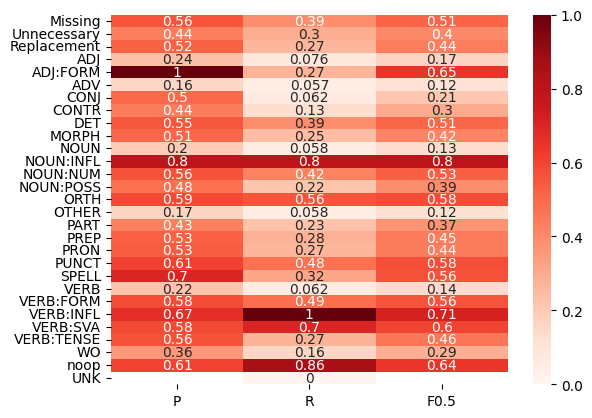

In [ ]:
sns.heatmap(error_df[['P', 'R', 'F0.5']], vmin=0.0, vmax=1.0, cmap='Reds', annot=True, yticklabels=True)
plt.show()

In [ ]:
CUSTOM_TESTS = [
    ['She saw a cat.', 'He screams out loud.'],  # PRON, VERB:TENSE
    ['The P versus NP problem is an unsolved problem in computer science.', 'No one has solved them to this day.'],  # PRON
    ['The Millennium Prize Problems are seven very complex mathematical problems.', 'No one has solved it to this day.'],
    ['Car crashes are easily preventable.', 'Most cases occurred because the driver was careless.'],  # VERB:TENSE
    ['A study was done on 1000 car crashes.', 'Most cases occur because the driver is careless.'],
    ["If he thinks about it more, I'm sure he'll figure something out.", 'The right idea eventually came to him.'],  # VERB:TENSE
    ['The right idea will eventually come to him.', 'Many weeks of effort finally paid off.'],
    ['Everyone knows that cats are adorable.', 'But they make for great companions.'],  # CONJ
    ['Cats can be annoying at times.', 'And they make for great companions.'],
    ['I visit the apple store frequently.', "I'm always eager to check out the latest phone."],  # ORTH
    ['I visit the apple store frequently.', 'Fruit works great as a snack.'],
    ['Tom told his sister there was a spider in her hair.', 'Cried out in alarm.'],  # PRON
    ['There have been complaints about long queues in the canteens.', "I'm looking them now."],  # PREP
    ["I lost my earphones earlier.", "I'm looking them now."]
]

In [ ]:
for para in CUSTOM_TESTS:
    tokenized_para = [' '.join(tok.text for tok in nlp.tokenizer(sent)) for sent in para]
    for i, sent in enumerate(tokenized_para):
        sample = {'original': sent, 'paragraph': tokenized_para, 'pos': i}
        print('ORIGINAL:', sent)
        print('CORRECTED:', generate_correction(model, tokenizer, sample))
        print()

ORIGINAL: She saw a cat .
CORRECTED: She saw a cat .

ORIGINAL: He screams out loud .
CORRECTED: He screams out loud .

ORIGINAL: The P versus NP problem is an unsolved problem in computer science .
CORRECTED: The P versus NP problem is an unsolved problem in computer science .

ORIGINAL: No one has solved them to this day .
CORRECTED: No one has solved them to this day .

ORIGINAL: The Millennium Prize Problems are seven very complex mathematical problems .
CORRECTED: The Millennium Prize Problems are seven very complex mathematical problems .

ORIGINAL: No one has solved it to this day .
CORRECTED: No one has solved it to this day .

ORIGINAL: Car crashes are easily preventable .
CORRECTED: Car crashes are easily preventable .

ORIGINAL: Most cases occurred because the driver was careless .
CORRECTED: Most cases occurred because the driver was careless .

ORIGINAL: A study was done on 1000 car crashes .
CORRECTED: A study was done on 1000 car crashes .

ORIGINAL: Most cases occur bec